<a href="https://colab.research.google.com/github/biswa-13/TensorFlow-Practice/blob/master/TF8_Tensorflow_Lite_Step_By_Step_Demostration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Steps to be followed for coverting a model into a tensorflow lite model which can be deployed to the mobile/IOT devices


*   Build a model
*   Save the model using the save_model.save()
*   Load the model
*   initilize the model for tflite
*   optimize the model
*   Quantize the model using the representative dataset
** for quantization we need a representative data generatore function
*   Restricting the model operations
*   Convert the model into the tensorflow lite
*   Test the new model

References


*   https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_lite/tflite_c01_linear_regression.ipynb#scrollTo=FOAIMETeJmkc


*  https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_lite/tflite_c02_transfer_learning.ipynb#scrollTo=FlsEcKVeuCnf






In [2]:
# - import required libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import pathlib
import matplotlib.pyplot as plt
import numpy as np

dataset_name = "cats_vs_dogs"
epochs = 6
batch_size = 32
img_size = 224
model_url = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

print("Finish - import required libraries")

Finish - import required libraries


In [0]:
# downlaod the dataset and separate the training set, validation set & testing set
(dataset_train, dataset_val, dataset_test), datset_info = tfds.load(dataset_name, split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], as_supervised = True, with_info=True)
print("dataset_info -->\n", datset_info)

print("Finish - downlaod the dataset and separate the training set, validation set & testing set")

In [0]:
# building a function to format the images as required by the model
def format_images(image,  label):
  image = tf.image.resize(image, (img_size, img_size))/255.0
  return image, label


In [46]:
# formating the datasets to fit into the tensorflow

dataset_train_formated = dataset_train.shuffle(2000).map(format_images).batch(batch_size).prefetch(1)
dataset_val_formated = dataset_val.map(format_images).batch(batch_size).prefetch(1)
dataset_test_formated = dataset_test.map(format_images).batch(1)

print("Finish - formating the datasets to fit into the tensorflow")

Finish - formating the datasets to fit into the tensorflow


In [33]:
# load the pre-trained model
feature_layer = hub.KerasLayer(model_url, input_shape=(img_size, img_size, 3))
feature_layer.trainable = False

print("Finish - load the pre-trained model")

Finish - load the pre-trained model


In [0]:
# updating the dense layer of the model and building the the model
dataset_classes = datset_info.features['label'].num_classes
dataset_labels = datset_info.features['label'].names
model = tf.keras.Sequential([
                             feature_layer,
                             tf.keras.layers.Dense(dataset_classes)
])

# compiling the model
model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=["accuracy"])
model.summary()
print("Finish building & compiling the model")

In [0]:
# training the model
history = model.fit(dataset_train_formated, epochs= epochs, validation_data= dataset_val_formated)

print("Finish training the model")

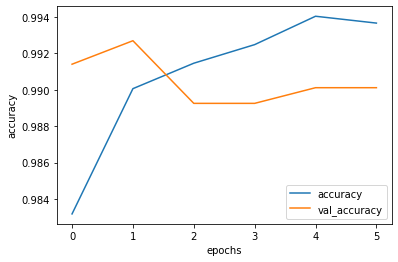

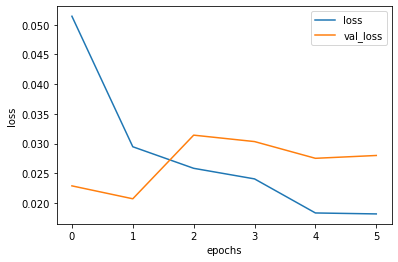

In [36]:
# plotting the model training graph
def plot_graph(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history["val_"+string])
  plt.xlabel("epochs")
  plt.ylabel(string)
  plt.legend([string, "val_"+string])
  plt.show()

plot_graph(history, "accuracy")
plot_graph(history, "loss")

In [37]:
# # exporting the model
model_name = "cat_dog_classifier_saved_model"
tf.saved_model.save(model, model_name)


INFO:tensorflow:Assets written to: cat_dog_classifier_saved_model/assets


INFO:tensorflow:Assets written to: cat_dog_classifier_saved_model/assets


In [0]:
# %%bash -s $model_name
# saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

# %%bash -s $CATS_VS_DOGS_SAVED_MODEL
# saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

In [0]:
# # load the model
existing_model = tf.saved_model.load(model_name)

In [0]:
# print(list(loaded.signatures.keys()))
# infer = loaded.signatures["serving_default"]
# print(infer.structured_input_signature)
# print(infer.structured_outputs)

In [0]:
# defining a generator function which will generate the representational data for the tflite model

def data_generator():
  for input_data, _ in dataset_test_formated.take(100):
    yield [input_data]
    

In [0]:
# # initialize the tflite conversion process

converter = tf.lite.TFLiteConverter.from_saved_model(model_name)

# # # optimizing the model
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# # # quantizing the model using the representative dataset
converter.representative_dataset = data_generator

# # restricting the model operations for fully integer point operations
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.allow_custom_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# # finally convert the model
converted_tflite_model = converter.convert()

# #  save the model into the disk
open(tflite_converted_file, 'wb').write(converted_tflite_model)

In [13]:

tflite_converted_file = "cat_dog_tflite_model.tflite"


# create the labels.txt
labels = ['cat', 'dog']

with open('labels.txt', 'w') as f:
  f.write('\n'.join(labels))

# download the model and label.txt for future use
try:
  from google.colab import files
  files.download('cat_dog_tflite_model.tflite')
  files.download('labels.txt')
except:
  pass

print("Finish - conversion of the model to the tflite model")


Finish - conversion of the model to the tflite model


In [11]:
!pwd
!ls

/content
cat_dog_tflite_model.tflite  labels.txt  sample_data


In [0]:
# # Test the TFLite model using the Python Interpreter

# ## load tflite model and allocate tensors
# tflite_converted_file = "cat_dog_tflite_model.tflite"
# interpretor = tf.lite.Interpreter(model_path=tflite_converted_file)
# interpretor.allocate_tensors()

# # get input & output tensors
# input_index = interpreter.get_input_details()[0]["index"]
# output_index = interpreter.get_output_details()[0]["index"]

# # point the data to be testing and run the interpretor
# interpretor.set_tensor()
